In [ ]:
!pip install qiskit==0.43.0

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
!pip show qiskit

Name: qiskit
Version: 0.43.0
Summary: Software for developing quantum computing programs
Home-page: https://qiskit.org/
Author: Qiskit Development Team
Author-email: hello@qiskit.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: qiskit-aer, qiskit-ibmq-provider, qiskit-terra
Required-by: 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math

from qiskit.opflow import I, Z
# from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, TwoLocal, EfficientSU2, RealAmplitudes, QAOAAnsatz
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit import execute, Aer
from qiskit.primitives import Sampler

<ipython-input-2-533ea895dd21>:5: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, Z


In [ ]:
class VQE:
    def __init__(self):
        self.counts = []
        self.values = []

    def store_intermediate_result(self, eval_count, parameters, mean, std):
        self.counts.append(eval_count)
        self.values.append(mean)

    def get_vqe(self):
        self.counts = []
        self.values = []
        vqe = SamplingVQE(
            Sampler(),
            ansatz=EfficientSU2(4, reps = 1),
            optimizer=COBYLA(maxiter=45),
            aggregation=0.10,
            callback=self.store_intermediate_result,
        )
        return vqe

    def plot_graph(self):
        fig = plt.figure()

        plt.plot(self.counts, self.values)
        plt.ylabel("Conformation Energy")
        plt.xlabel("VQE Iterations")

        # fig.add_axes([0.44, 0.51, 0.44, 0.32])
        # plt.plot(counts[35:], values[35:])

        plt.ylabel("Conformation Energy")
        plt.xlabel("VQE Iterations")
        plt.show()

In [ ]:
class EnergyTerm:
    def __init__(self, coefficient, indices):
        self.coefficient = coefficient
        self.indices = sorted(indices)

    def __mul__(self, other):
        new_coefficient = self.coefficient * other.coefficient
        new_indices = sorted(list(set(self.indices + other.indices)))
        return EnergyTerm(new_coefficient, new_indices)
    def print(self):
        print("(", self.coefficient, ",", self.indices, ")")

In [ ]:
class Energy:
    def __init__(self):
        self.terms = []

    def add_term(self, term_object):
        for term in self.terms:
            if term.indices == term_object.indices:
                term.coefficient += term_object.coefficient
                self.delete_zero_coefficients()
                return
        self.terms.append(term_object)

    def __add__(self, other):
        new_energy = self.copy()
        for term in other.terms:
            new_energy.add_term(term)
        new_energy.delete_zero_coefficients()
        return new_energy

    def scale(self, m):
        self.terms = [EnergyTerm(term.coefficient * m, term.indices) for term in self.terms]

    def delete_zero_coefficients(self):
        self.terms = [term for term in self.terms if term.coefficient != 0]

    def __sub__(self, other):
        new_energy = self.copy()
        for term in other.terms:
            new_energy.add_term(EnergyTerm(-term.coefficient, term.indices))
        new_energy.delete_zero_coefficients()
        return new_energy

    def __mul__(self, other):
        new_energy = Energy()
        for term1 in self.terms:
            for term2 in other.terms:
                new_term = term1 * term2
                new_energy.add_term(new_term)
        return new_energy

    def square(self):
        return self * self

    def print(self):
        for term in self.terms:
            term.print()

    def copy(self):
        E = Energy()
        E.terms = self.terms.copy()
        return E

In [ ]:
class ProteinFolding:
    def __init__(self, protein, penalty_overlap=3000, interaction_energy=-10):
        self.vqe = VQE()
        self.protein = protein
        self.N = len(protein)
        self.penalty_overlap = penalty_overlap
        self.interaction_energy = interaction_energy
        self.turn_qubit = 2 * self.N - 5
        self.ancilla_qubit = self.count_ancilla_bits()
        self.energy_back = None
        self.energy_overlap = None
        self.energy_pair = None
        self.energy_equation = None
        # self.derive_energy_equations()

    def meu(self, i, j):
        if i <= j:
            return 0
        d = i - j
        cnt = 0
        cur = 1
        while cur < d:
            cur *= 2
            cnt += 1
        cnt *= 2
        cnt *= (1 + i - j) % 2
        return cnt

    def count_slack_variable(self):
        cnt = 0
        for i in range(1, self.N - 4 + 1):
            for j in range(i + 4, self.N + 1):
                cnt += (1 + j + i) % 2
        return cnt

    def count_ancilla_bits(self):
        cnt = 0
        for i in range(1, self.N - 4 + 1):
            for j in range(i + 4, self.N + 1):
                cnt += self.meu(j, i)
        return cnt

    def dx_p(self, j):
        cur = Energy()
        cur.add_term(EnergyTerm(1, [2 * j - 3]))
        cur.add_term(EnergyTerm(-1, [2 * j - 3, 2 * j - 4]))
        return cur

    def dx_n(self, j):
        cur = Energy()
        cur.add_term(EnergyTerm(1, [2 * j - 4]))
        cur.add_term(EnergyTerm(-1, [2 * j - 3, 2 * j - 4]))
        return cur

    def dy_p(self, j):
        cur = Energy()
        cur.add_term(EnergyTerm(1, [2 * j - 3, 2 * j - 4]))
        return cur

    def dy_n(self, j):
        cur = Energy()
        cur.add_term(EnergyTerm(1, []))
        cur.add_term(EnergyTerm(-1, [2 * j - 3]))
        cur.add_term(EnergyTerm(-1, [2 * j - 4]))
        cur.add_term(EnergyTerm(1, [2 * j - 3, 2 * j - 4]))
        return cur

    def back_turn(self, j):
        if j == 1:
            return Energy()
        if j == 2:
            cur = Energy()
            cur.add_term(EnergyTerm(1, [1, 2]))
            cur.add_term(EnergyTerm(1, [2, 3]))
            cur.add_term(EnergyTerm(-2, [1, 2, 3]))
            return cur

        return (self.dx_p(j) * self.dx_n(j + 1)) + (self.dx_n(j) * self.dx_p(j + 1)) + (self.dy_p(j) * self.dy_n(j + 1)) + (self.dy_n(j) * self.dy_p(j + 1))

    def get_x(self, n):
        x = Energy()
        if n == 1:
            return x

        x.add_term(EnergyTerm(1, []))
        cof = 1
        for i in range(1, 2 * (n - 2)):
            x.add_term(EnergyTerm(cof, [i]))
            cof *= -1
        return x

    def get_y(self, n):
        y = Energy()
        if n < 3:
            return y

        y.add_term(EnergyTerm(-(n - 2), []))
        for i in range(1, 2 * (n - 2)):
            y.add_term(EnergyTerm(1, [i]))
        return y

    def get_g(self, i, j):
        return (self.get_x(i) - self.get_x(j)).square() + (self.get_y(i) - self.get_y(j)).square()

    def get_c(self, n, m):
        cnt = 2 * self.N - 4
        for i in range(3, n):
            for j in range(1, i - 4 + 1):
                cnt += self.meu(i, j)
        for i in range(1, m):
            cnt += self.meu(n, i)
        return cnt

    def alpha(self, i, j):
        E = Energy()
        c_ij = self.get_c(i, j)
        for k in range(0, self.meu(i, j)):
            E.add_term(EnergyTerm(2**k, [c_ij + k]))
        return E

    def gamma(self, i, j):
        E = Energy()
        E.add_term(EnergyTerm(2**self.meu(i, j), []))
        E -= self.get_g(i, j)
        E -= self.alpha(i, j)
        E *= E
        return E

    def build_energy_back(self):
        E = Energy()
        for j in range(2, self.N - 1):
            E += self.back_turn(j)
        # E.scale(self.penalty_overlap)
        return E.copy()

    def build_energy_overlap(self):
        E = Energy()
        for i in range(1, self.N - 4 + 1):
            for j in range(i + 4, self.N + 1):
                if (1 + i + j) % 2 == 1:
                    E += self.gamma(j, i)
        return E

    def build_energy_pair(self):
        E = Energy()
        for i in range(1, self.N):
            for j in range(i + 3, self.N + 1):
                if self.protein[i - 1] == 'H' and self.protein[j - 1] == 'H' and (i + j) % 2 == 1:
                    E.add_term(EnergyTerm(2, []))
                    E -= self.get_g(i, j)
                    # print("interaction ", i, j)

        # E.scale(self.interaction_energy)
        return E

    def build_energy_equation(self):
        E = Energy()
        # E += self.energy_back
        # E += self.energy_overlap
        # E += self.energy_pair
        back = self.build_energy_back()
        overlap = self.build_energy_overlap()
        pair = self.build_energy_pair()
        back.scale(self.penalty_overlap)
        overlap.scale(self.penalty_overlap)
        pair.scale(self.interaction_energy)
        E = back + overlap + pair
        return E

    def derive_energy_equations(self):
        self.energy_back = self.build_energy_back()
        self.energy_overlap = self.build_energy_overlap()
        self.energy_pair = self.build_energy_pair()
        self.energy_equation = self.build_energy_equation()

    def get_energy_back(self):
        if self.energy_back == None:
            self.derive_energy_equations()
        return self.energy_back

    def get_energy_overlap(self):
        if self.energy_overlap == None:
            self.derive_energy_equations()
        return self.energy_overlap

    def get_energy_pair(self):
        if self.energy_pair == None:
            self.derive_energy_equations()
        return self.energy_pair

    def equation_to_latex(self, equation):
        latex_equation = r"" #"$"
        f = 0
        for term in equation.terms:
            coefficient = term.coefficient
            indices = term.indices

            if f == 1 and coefficient > 0:
                latex_equation += " + "
            elif f == 1 and coefficient < 0:
                latex_equation += " - "
            f = 1

            if coefficient != 1:
                latex_equation += str(abs(coefficient))

            for index in indices:
                if index < 10:
                   latex_equation += f"q_{index}"
                else:
                    latex_equation += f"q_{{{'{:02d}'.format(index)}}}"

        latex_equation += "" # "$"

        # display(Math(latex_equation))
        return latex_equation

    def display_energy_back(self):
        energy_back_latex = self.equation_to_latex(self.build_energy_back())
        styled_equation = f"$E_{{\mathrm{{back}}}} = {self.penalty_overlap} \\times ({energy_back_latex})$"
        display(Math(styled_equation))

    def display_energy_overlap(self):
        energy_overlap_latex = self.equation_to_latex(self.build_energy_overlap())
        styled_equation = f"$E_{{\mathrm{{overlap}}}} = {self.penalty_overlap} \\times ({energy_overlap_latex})$"
        display(Math(styled_equation))

    def display_energy_pair(self):
        energy_pair_latex = self.equation_to_latex(self.build_energy_pair())
        styled_equation = f"$E_{{\mathrm{{pair}}}} = {self.interaction_energy} \\times ({energy_pair_latex})$"
        display(Math(styled_equation))

    def display_energy_equation(self):
        energy_equation_latex = self.equation_to_latex(self.build_energy_equation())
        styled_equation = f"$E_{{\mathrm{{overll}}}} = {energy_equation_latex}$"
        display(Math(styled_equation))

    def get_operator_term(self, num_qubits, q_indices): # 1 based index
        q = 0.5 * (I - Z)

        new_indices = [x - 1 for x in q_indices] # make 0 based index
        if 0 in new_indices:
            operator = q
        else:
            operator = I
        for i in range(1, num_qubits):
            if i in new_indices:
                operator = q ^ operator
            else:
                operator = I ^ operator

        return operator

    def get_hamiltonian(self):
        H = 0
        num_qubits = self.turn_qubit + self.ancilla_qubit
        print("Total qubit: ", num_qubits)
        energy_equation = self.build_energy_equation()
        for term in energy_equation.terms:
            term_value = term.coefficient * self.get_operator_term(num_qubits, term.indices)
            H += term_value
        # print("Hamiltonian (H):", H)
        return H

    def get_direction(self, raw_result):
        #probs = raw_result.eigenstate.binary_probabilities()
        #best_turn_sequence = max(probs, key=probs.get)
        #dir = "010" + best_turn_sequence[::-1]
        dir = "010" + raw_result.best_measurement['bitstring'][::-1]
        return dir

    def plot_protein_stylishly(self, direction_string):
        # Initialize grid and positions
        grid = 20
        spacing = 5
        # x, y = (grid) // 2, (grid) // 2
        x, y = 0, 5
        positions = [(x, y)]

        # Place amino acids on grid according to directions
        for i in range(self.N - 1):
            direction = direction_string[2 * i : 2 * i + 2]
            if direction == "00":
                y -= spacing
            elif direction == "11":
                y += spacing
            elif direction == "10":
                x -= spacing
            elif direction == "01":
                x += spacing
            positions.append((x, y))

        # Create plot
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        plt.grid(which='both', linestyle='-', linewidth=2, alpha=0.5)

        # Plot solid lines between adjacent amino acids
        for i, (x, y) in enumerate(positions[:-1]):
            x_next, y_next = positions[i + 1]
            plt.plot([x, x_next], [y, y_next], linestyle="-", color="black", alpha=0.7, linewidth=2)

        # Plot individual amino acids as circles
        for i, (x, y) in enumerate(positions):
            color = "red" if self.protein[i] == "H" else "green"
            plt.plot(x, y, marker='o', markersize=20, markeredgecolor='black', color=color, alpha=0.7)
            plt.text(x, y, self.protein[i], color='white', fontsize=15, fontweight='bold', ha='center', va='center')

        # Plot dotted lines for interactions
        for i in range(self.N):
            for j in range(i + 1, self.N):
                x1, y1 = positions[i]
                x2, y2 = positions[j]
                if self.protein[i] == "H" and self.protein[j] == "H":
                    if abs(x1 - x2) == spacing and abs(y1 - y2) == 0:
                        plt.plot([x1, x2], [y1, y2], linestyle="--", color="gray", alpha=0.5, linewidth=2)
                    if abs(x1 - x2) == 0 and abs(y1 - y2) == spacing:
                        plt.plot([x1, x2], [y1, y2], linestyle="--", color="blue", alpha=0.5, linewidth=2)

        plt.xlim([-grid, grid])
        plt.ylim([-grid, grid])
        plt.show()

    def get_vqe(self):
        return self.vqe.get_vqe()

    def get_fold(self):
        H = self.get_hamiltonian()
        raw_result = self.get_vqe().compute_minimum_eigenvalue(H)
        turn_sequence = self.get_direction(raw_result)
        print("Turn sequence: ", turn_sequence[0: 2 * self.N - 2])
        # print_energy(turn_sequence)

        print("Protein = ", self.protein)
        self.plot_protein_stylishly(turn_sequence)

    def print_summary(self):
        print("Protein = ", self.protein)
        print("Amino acid beads, N = ", self.N)
        print("Total qubit: ", self.turn_qubit + self.ancilla_qubit)
        print("Number of terms in energy equation: ", len(self.build_energy_equation().terms))

    def plot_graph(self):
        self.vqe.plot_graph()

In [ ]:
obj = ProteinFolding(protein = "HPHHPH")
# obj = ProteinFolding(protein = "HPPHHH", penalty_overlap=3000, interaction_energy= -10)
# obj = ProteinFolding(protein = "HPHPHPH", penalty_overlap=3000, interaction_energy= -10)

In [ ]:
obj.print_summary()

Protein =  HPHHPH
Amino acid beads, N =  6
Total qubit:  15
Number of terms in energy equation:  202


In [ ]:
obj.display_energy_back()

<IPython.core.display.Math object>

In [ ]:
obj.display_energy_overlap()

<IPython.core.display.Math object>

In [ ]:
obj.display_energy_pair()

<IPython.core.display.Math object>

In [ ]:
obj.display_energy_equation()

<IPython.core.display.Math object>

Total qubit:  15
Turn sequence:  0100100001
Protein =  HPHHPH


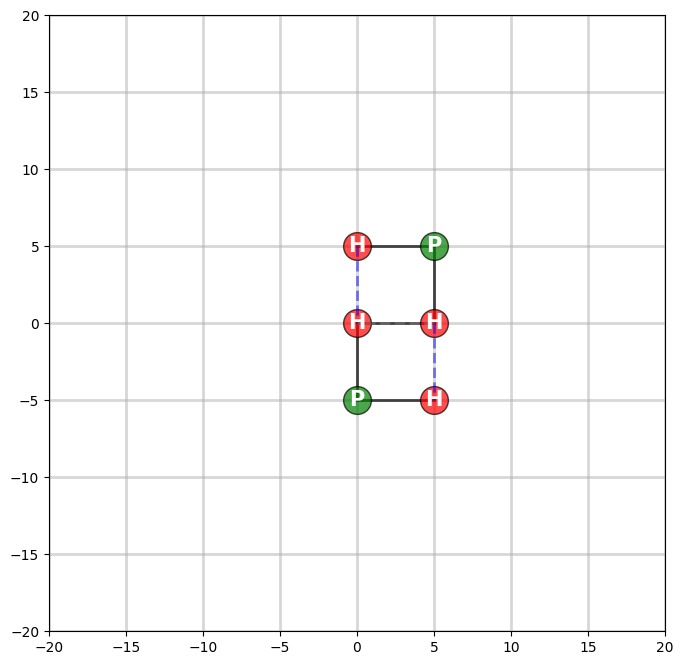

In [ ]:
obj.get_fold()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


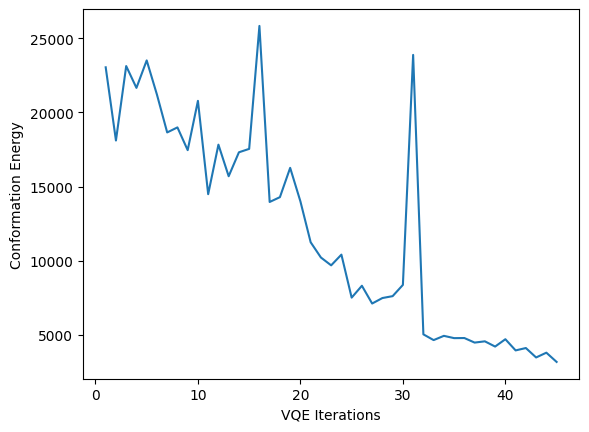

In [ ]:
obj.plot_graph()

In [ ]:
obj = ProteinFolding(protein = "HPPH")

In [ ]:
obj.print_summary()

Protein =  HPPH
Amino acid beads, N =  4
Total qubit:  3
Number of terms in energy equation:  6


Total qubit:  3
Turn sequence:  010010
Protein =  HPPH


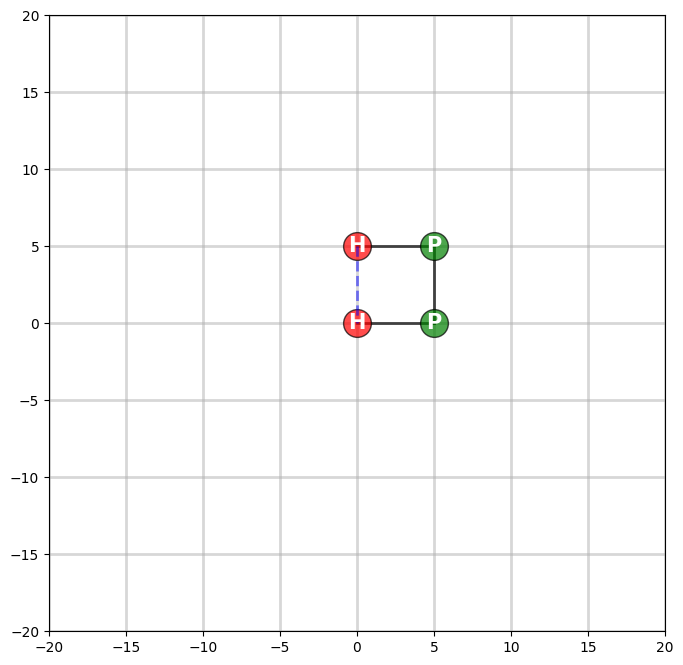

In [ ]:
obj.get_fold()

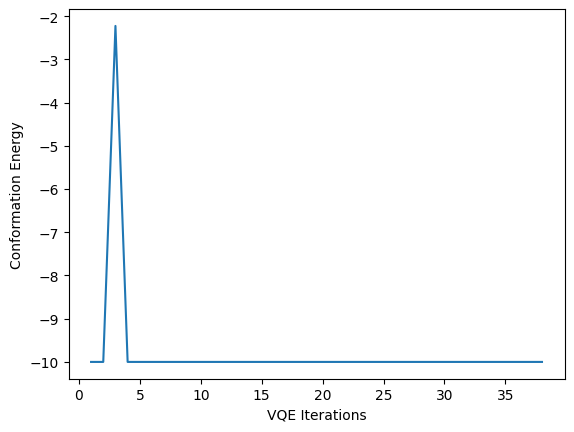

In [ ]:
obj.plot_graph()

In [ ]:
obj = ProteinFolding(protein = "PHHPH")
obj.print_summary()

Protein =  PHHPH
Amino acid beads, N =  5
Total qubit:  9
Number of terms in energy equation:  75


In [ ]:
obj.display_energy_back()

<IPython.core.display.Math object>

In [ ]:
obj.display_energy_overlap()

<IPython.core.display.Math object>

In [ ]:
obj.display_energy_pair()

<IPython.core.display.Math object>

In [ ]:
obj.display_energy_equation()

<IPython.core.display.Math object>

Total qubit:  9
Turn sequence:  01000111
Protein =  PHHPH


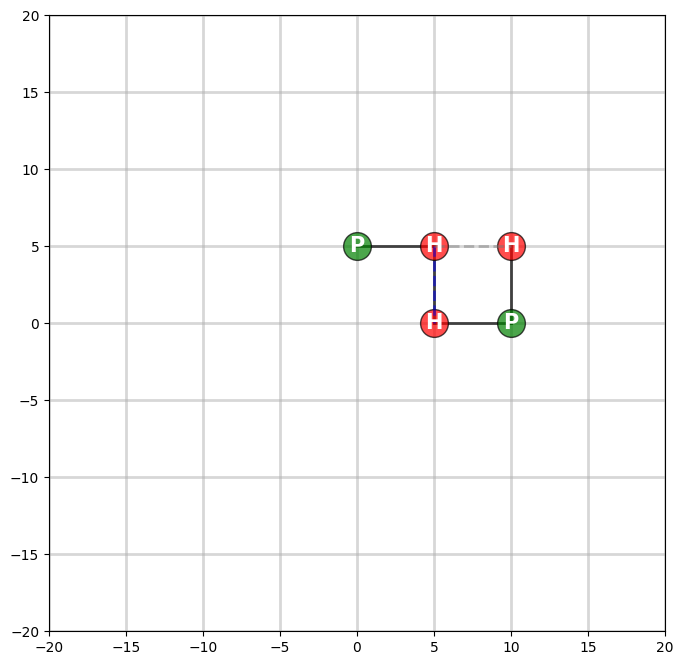

In [ ]:
obj.get_fold()

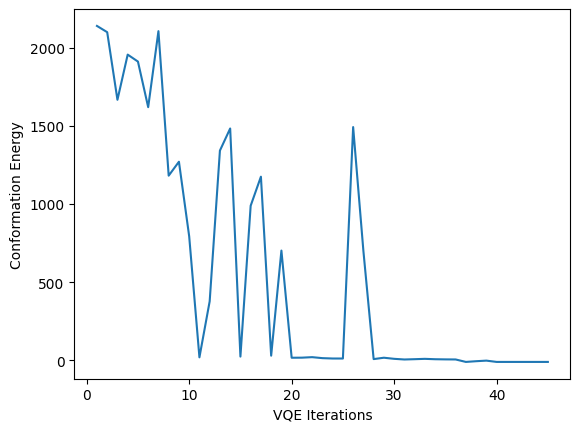

In [ ]:
obj.plot_graph()

In [ ]:
obj = ProteinFolding(protein = "HHPPHPH")
obj.print_summary()
# obj.display_energy_back()
# obj.display_energy_overlap()
# obj.display_energy_pair()
# obj.display_energy_equation()
# obj.get_fold()

Protein =  HHPPHPH
Amino acid beads, N =  7
Total qubit:  27
Number of terms in energy equation:  577


In [ ]:
obj = ProteinFolding(protein = "HHPPHPHH")
obj.print_summary()
obj.display_energy_back()
obj.display_energy_overlap()
obj.display_energy_pair()
obj.display_energy_equation()
# obj.get_fold()

Protein =  HHPPHPHH
Amino acid beads, N =  8
Total qubit:  39
Number of terms in energy equation:  1110


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
obj = ProteinFolding(protein = "HPHPPHHP")
obj.print_summary()

Protein =  HPHPPHHP
Amino acid beads, N =  8
Total qubit:  39
Number of terms in energy equation:  1110


In [ ]:
obj = ProteinFolding(protein = "PHPHPPHHP")
obj.print_summary()

Protein =  PHPHPPHHP
Amino acid beads, N =  9
Total qubit:  57
Number of terms in energy equation:  2129


In [ ]:
obj = ProteinFolding(protein = "HPHPPHPHHP")
obj.print_summary()

Protein =  HPHPPHPHHP
Amino acid beads, N =  10
Total qubit:  75
Number of terms in energy equation:  3423


In [ ]:
obj = ProteinFolding(protein = "HHPHPPPHPHP")
obj.print_summary()

Protein =  HHPHPPPHPHP
Amino acid beads, N =  11
Total qubit:  101
Number of terms in energy equation:  5692


In [ ]:
import random
from tabulate import tabulate

# Initialize an empty list to store results
results = []

# Loop over N values from 4 to 20
for N in range(4, 21):
    # Generate a random protein sequence of length N
    random_protein = ''.join(random.choices(['H', 'P'], k=N))

    # Create an instance of ProteinFolding with the random protein sequence
    obj = ProteinFolding(protein=random_protein)

    # Calculate relevant quantities
    Turn_Qubit = obj.turn_qubit
    Ancilla_Qubit = obj.ancilla_qubit
    Total_Qubit = obj.turn_qubit + obj.ancilla_qubit

    # Store the results in a dictionary
    results.append({'N': N, 'Turn Qubit': Turn_Qubit, 'Ancilla Qubit': Ancilla_Qubit, 'Total Qubit': Total_Qubit})

# Print the stylish table
print(tabulate(results, headers="keys", tablefmt="fancy_grid"))


╒═════╤══════════════╤═════════════════╤═══════════════╕
│   N │   Turn Qubit │   Ancilla Qubit │   Total Qubit │
╞═════╪══════════════╪═════════════════╪═══════════════╡
│   4 │            3 │               0 │             3 │
├─────┼──────────────┼─────────────────┼───────────────┤
│   5 │            5 │               4 │             9 │
├─────┼──────────────┼─────────────────┼───────────────┤
│   6 │            7 │               8 │            15 │
├─────┼──────────────┼─────────────────┼───────────────┤
│   7 │            9 │              18 │            27 │
├─────┼──────────────┼─────────────────┼───────────────┤
│   8 │           11 │              28 │            39 │
├─────┼──────────────┼─────────────────┼───────────────┤
│   9 │           13 │              44 │            57 │
├─────┼──────────────┼─────────────────┼───────────────┤
│  10 │           15 │              60 │            75 │
├─────┼──────────────┼─────────────────┼───────────────┤
│  11 │           17 │         

In [ ]:
# obj = ProteinFolding(protein = "HPHH")
# obj.print_summary()
# obj.display_energy_back()
# obj.display_energy_overlap()
# obj.display_energy_pair()
# obj.display_energy_equation()
# obj.get_fold()